A notebook estimating soil fluid EC for the top 3 metres using an empirical relationship derived at the sonic boreholes. The linear model we are employing is:

EC = 5.3714 x AEM_conductivity

Neil Symington
neil.symington@ga.gov.au

In [1]:
%matplotlib inline

In [2]:
import pandas
import rasterio
import numpy as np
from hydrogeol_utils import SNMR_utils, AEM_utils, spatial_functions, borehole_utils
import netCDF4
import math
import os, glob
import gc
import affine as Affine
import rasterio
from rasterio import Affine
from rasterio.warp import reproject, Resampling
from scipy import interpolate, stats
import matplotlib.pyplot as plt

In [3]:
# OPen the AEM grids and average to get conductivity for the top 3 metres

indir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\AEM\EK_nbc_inversions\OrdKeep_borehole_constrained\gdal_grids\grids\layergrids"


condfile1 =  os.path.join(indir, 'layer_01_000.0_002.0_m.tif')
condfile2 =  os.path.join(indir, 'layer_02_002.0_004.0_m.tif')

# Define intervals array

intervals = np.nan*np.ones(shape = (2,2), dtype = np.float32)

src = rasterio.open(condfile1)

# Extract data as an array
cond_arr1 = src.read()[0]

# Get the affine and crs
aff = src.transform

src_crs=src.crs

intervals[0] = [float(condfile1.split('\\')[-1].split('_')[2]),
                float(condfile1.split('\\')[-1].split('_')[3])]

# Open the second layer
src = rasterio.open(condfile2)

# Extract data as an array
cond_arr2 = src.read()[0]

intervals[1] = [float(condfile2.split('\\')[-1].split('_')[2]),
                float(condfile2.split('\\')[-1].split('_')[3])]

thickness = spatial_functions.depth_to_thickness(intervals)[:,0]
    
# Now get the average of the first 3 metres

cond = 10**(((thickness[0] * np.log10(cond_arr1)) + (1. * np.log10(cond_arr2)))/(3.))

# Make all nulls equal to np.nan

cond[cond == 0] = np.nan

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10


In [5]:
# Now we apply our empirical function to find fluid EC

fluid_EC = 5.3714 * cond


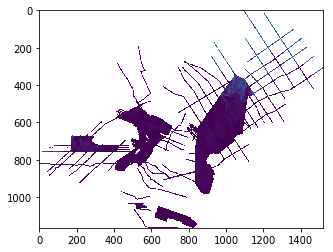

In [6]:
# Use this plot to slice to our area of interest


plt.close()
plt.imshow(fluid_EC)

plt.show()

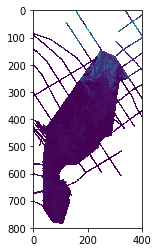

In [7]:
xind1, xind2 = 800, 1200

yind1, yind2 = 200,1000

plt.close()
plt.imshow(fluid_EC[yind1:yind2, xind1:xind2])

plt.show()

In [12]:
# Now we resample to to image the palaeovalley
new_aff = Affine(aff.a, aff.b, aff.c + aff.a * xind1,
                        aff.d, aff.e, aff.f + (aff.e * yind1))

In [13]:
new_aff

Affine(100.0, 0.0, 493550.0,
       0.0, -100.0, 8340850.0)

In [11]:
aff

Affine(100.0, 0.0, 413550.0,
       0.0, -100.0, 8360850.0)

In [22]:
# NOw right the output to a raster

outfile = r'\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\OrdKeep_water_quality\fluid_EC_uS_per_cm_top3m.tif'

# Define the outout array based on our slice values
out_arr = fluid_EC[yind1:yind2, xind1:xind2]

new_dataset = rasterio.open(outfile, 'w', driver='GTiff',
                                height= out_arr.shape[0], width=out_arr.shape[1],
                                count=1, dtype=np.float32,
                                crs=src.crs, transform=new_aff)
new_dataset.write(out_arr * 10000, 1)

new_dataset.close()

In [20]:
# Now we convert this to a salt store estimate

outfile = r'\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\OrdKeep_water_quality\OrdKeep_salt_store.tif'


new_dataset = rasterio.open(outfile, 'w', driver='GTiff',
                                height= out_arr.shape[0], width=out_arr.shape[1],
                                count=1, dtype=np.float32,
                                crs=src.crs, transform=new_aff)
new_dataset.write(out_arr * 1.2798, 1)

new_dataset.close()